## Wrapper Methods

In this project, you'll analyze data from a survey conducted by Fabio Mendoza Palechor and Alexis de la Hoz Manotas that asked people about their eating habits and weight. The data was obtained from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Estimation+of+obesity+levels+based+on+eating+habits+and+physical+condition+). Categorical variables were changed to numerical ones in order to facilitate analysis.

First, you'll fit a logistic regression model to try to predict whether survey respondents are obese based on their answers to questions in the survey. After that, you'll use three different wrapper methods to choose a smaller feature subset.

You'll use sequential forward selection, sequential backward floating selection, and recursive feature elimination. After implementing each wrapper method, you'll evaluate the model accuracy on the resulting smaller feature subsets and compare that with the model accuracy using all available features.

In [1]:
# %%
# Import libraries
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
%matplotlib inline

## Evaluating a Logistic Regression Model

The data set `obesity` contains 18 predictor variables. Here's a brief description of them.

* `Gender` is `1` if a respondent is male and `0` if a respondent is female.
* `Age` is a respondent's age in years.
* `family_history_with_overweight` is `1` if a respondent has family member who is or was overweight, `0` if not.
* `FAVC` is `1` if a respondent eats high caloric food frequently, `0` if not.
* `FCVC` is `1` if a respondent usually eats vegetables in their meals, `0` if not.
* `NCP` represents how many main meals a respondent has daily (`0` for 1-2 meals, `1` for 3 meals, and `2` for more than 3 meals).
* `CAEC` represents how much food a respondent eats between meals on a scale of `0` to `3`.
* `SMOKE` is `1` if a respondent smokes, `0` if not.
* `CH2O` represents how much water a respondent drinks on a scale of `0` to `2`.
* `SCC` is `1` if a respondent monitors their caloric intake, `0` if not.
* `FAF` represents how much physical activity a respondent does on a scale of `0` to `3`.
* `TUE` represents how much time a respondent spends looking at devices with screens on a scale of `0` to `2`.
* `CALC` represents how often a respondent drinks alcohol on a scale of `0` to `3`.
* `Automobile`, `Bike`, `Motorbike`, `Public_Transportation`, and `Walking` indicate a respondent's primary mode of transportation. Their primary mode of transportation is indicated by a `1` and the other columns will contain a `0`.

The outcome variable, `NObeyesdad`, is a `1` if a patient is obese and a `0` if not.

Use the `.head()` method and inspect the data.

In [2]:
# https://archive.ics.uci.edu/ml/datasets/Estimation+of+obesity+levels+based+on+eating+habits+and+physical+condition+

# Load the data
obesity = pd.read_csv("obesity.csv")

# Inspect the data
print("Dataset shape:", obesity.shape)
print("\nFirst 5 rows:")
print(obesity.head())

Dataset shape: (2111, 19)

First 5 rows:
   Gender   Age  family_history_with_overweight  FAVC  FCVC  NCP  CAEC  SMOKE  \
0       0  21.0                               1     0   2.0  3.0     1      0   
1       0  21.0                               1     0   3.0  3.0     1      1   
2       1  23.0                               1     0   2.0  3.0     1      0   
3       1  27.0                               0     0   3.0  3.0     1      0   
4       1  22.0                               0     0   2.0  1.0     1      0   

   CH2O  SCC  FAF  TUE  CALC  Automobile  Bike  Motorbike  \
0   2.0    0  0.0  1.0     0           0     0          0   
1   3.0    1  3.0  0.0     1           0     0          0   
2   2.0    0  2.0  1.0     2           0     0          0   
3   2.0    0  2.0  0.0     2           0     0          0   
4   2.0    0  0.0  0.0     1           0     0          0   

   Public_Transportation  Walking  NObeyesdad  
0                      1        0           0  
1        

In [3]:
print("\nData summary:")
print(obesity.describe().T)


Data summary:
                                 count       mean       std   min        25%  \
Gender                          2111.0   0.505921  0.500083   0.0   0.000000   
Age                             2111.0  24.312600  6.345968  14.0  19.947192   
family_history_with_overweight  2111.0   0.817622  0.386247   0.0   1.000000   
FAVC                            2111.0   0.883941  0.320371   0.0   1.000000   
FCVC                            2111.0   2.419043  0.533927   1.0   2.000000   
NCP                             2111.0   2.685628  0.778039   1.0   2.658738   
CAEC                            2111.0   1.140692  0.468543   0.0   1.000000   
SMOKE                           2111.0   0.020843  0.142893   0.0   0.000000   
CH2O                            2111.0   2.008011  0.612953   1.0   1.584812   
SCC                             2111.0   0.045476  0.208395   0.0   0.000000   
FAF                             2111.0   1.010298  0.850592   0.0   0.124505   
TUE                      

### Split the data into `X` and `y`

In order to use a linear regression model, you'll need to split the data into two parts: the predictor variables and an outcome variable. Do this by splitting the data into a DataFrame of predictor variables called `X` and a Series of outcome variables `y`.


Target variable distribution:
NObeyesdad
0    53.955471
1    46.044529
Name: proportion, dtype: float64


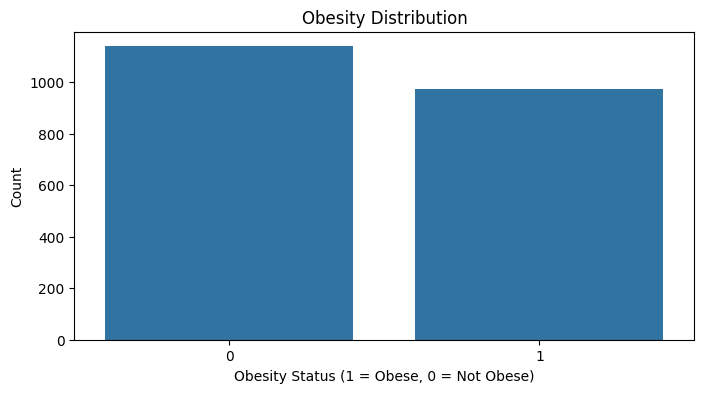

In [4]:
# Check target variable distribution
print("\nTarget variable distribution:")
print(obesity['NObeyesdad'].value_counts(normalize=True) * 100)
plt.figure(figsize=(8, 4))
sns.countplot(data=obesity, x='NObeyesdad')
plt.title('Obesity Distribution')
plt.xlabel('Obesity Status (1 = Obese, 0 = Not Obese)')
plt.ylabel('Count')
plt.show()

In [5]:
# Split features and target
X = obesity.drop(columns='NObeyesdad')
y = obesity['NObeyesdad']

# Store feature names for later use
features = X.columns

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [6]:
print(f"Training set shape: {X_train.shape}")
print(f"Testing set shape: {X_test.shape}")

Training set shape: (1688, 18)
Testing set shape: (423, 18)


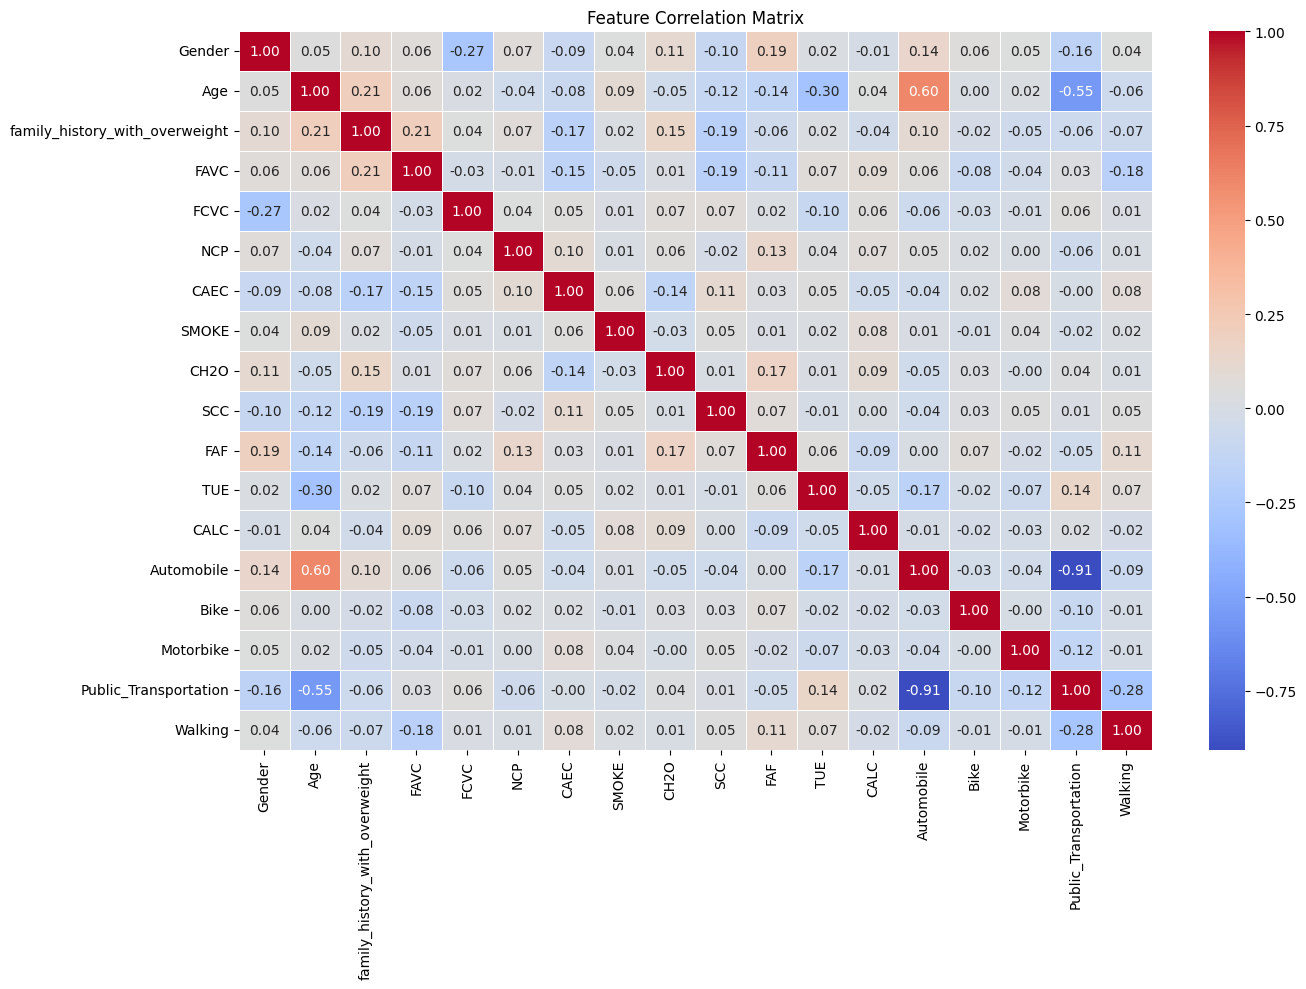

In [7]:
# Analyze feature correlations
plt.figure(figsize=(14, 10))
correlation_matrix = X.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Feature Correlation Matrix')
plt.tight_layout()
plt.show()

### Logistic regression model

Create a logistic regression model called `lr`. Include the parameter `max_iter=1000` to make sure that the model will converge when you try to fit it.

### Fit the model

Use the `.fit()` method on `lr` to fit the model to `X` and `y`.

In [8]:
# Create and fit logistic regression model
lr = LogisticRegression(max_iter=1000, random_state=42)
lr.fit(X_train, y_train)

LogisticRegression(max_iter=1000, random_state=42)

### Model accuracy

A model's _accuracy_ is the proportion of classes that the model correctly predicts. is Compute and print the accuracy of `lr` by using the `.score()` method. What percentage of respondents did the model correctly predict as being either obese or not obese? You may want to write this number down somewhere so that you can refer to it during future tasks.

In [9]:
# Evaluate model performance
train_accuracy = lr.score(X_train, y_train)
test_accuracy = lr.score(X_test, y_test)

print(f'Training Accuracy: {train_accuracy*100:.2f}%')
print(f'Testing Accuracy: {test_accuracy*100:.2f}%')

Training Accuracy: 77.61%
Testing Accuracy: 74.00%


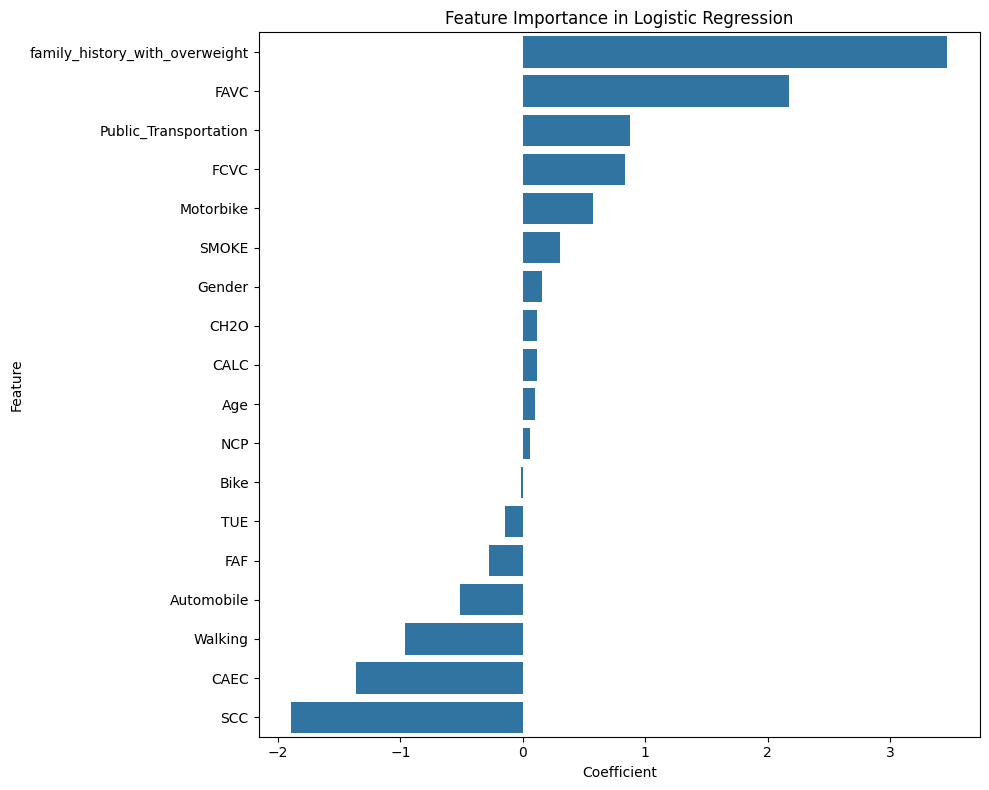

In [10]:
# Visualize feature importance
coefficients = pd.DataFrame({
    'Feature': features,
    'Coefficient': lr.coef_[0]
}).sort_values(by='Coefficient', ascending=False)

plt.figure(figsize=(10, 8))
sns.barplot(x='Coefficient', y='Feature', data=coefficients)
plt.title('Feature Importance in Logistic Regression')
plt.tight_layout()
plt.show()

## Sequential Forward Selection

Now that you've created a logistic regression model and evaluated its performance, you're ready to do some feature selection. 

Create a sequential forward selection model called `sfs`. 
* Be sure to set the `estimator` parameter to `lr` and set the `forward` and `floating` parameters to the appropriate values. 
* Also use the parameters `k_features=9`, `scoring='accuracy'`, and `cv=0`.

### Fit the model

Use the `.fit()` method on `sfs` to fit the model to `X` and `y`. This step will take some time (not more than a minute) to run.

In [11]:
# Create and fit sequential forward selection model
sfs = SFS(
    lr, 
    k_features=9, 
    forward=True, 
    floating=False, 
    scoring='accuracy', 
    cv=5,  # Use 5-fold cross-validation instead of no CV
    n_jobs=-1  # Use all available cores for parallel execution
)

print("Performing Sequential Forward Selection...")
sfs.fit(X_train, y_train)

Performing Sequential Forward Selection...


SequentialFeatureSelector(estimator=LogisticRegression(max_iter=1000,
                                                       random_state=42),
                          k_features=(9, 9), n_jobs=-1, scoring='accuracy')

### Inspect the results

Now that you've run the sequential forward selection algorithm on the logistic regression model with `X` and `y` you can see what features were chosen and check the model accuracy on the smaller feature set. Print `sfs.subsets_[9]` to inspect the results of sequential forward selection.

In [12]:
for key, value in sfs.subsets_[9].items():
    print(f'{key}: {value}')

feature_idx: (0, 1, 2, 3, 6, 10, 14, 15, 17)
cv_scores: [0.77514793 0.78106509 0.78106509 0.81008902 0.79821958]
avg_score: 0.7891173423700245
feature_names: ('Gender', 'Age', 'family_history_with_overweight', 'FAVC', 'CAEC', 'FAF', 'Bike', 'Motorbike', 'Walking')


### Chosen features and model accuracy

Use the dictionary `sfs.subsets_[9]` to print a tuple of chosen feature names. Then use it to print the accuracy of the model after doing sequential forward selection. How does this compare to the model's accuracy on all available features?

In [13]:
print(f'Feature names: {sfs.subsets_[9]['feature_names']}')
print(f'Accuracy score: {sfs.subsets_[9]['avg_score']}')

Feature names: ('Gender', 'Age', 'family_history_with_overweight', 'FAVC', 'CAEC', 'FAF', 'Bike', 'Motorbike', 'Walking')
Accuracy score: 0.7891173423700245


### Visualize model accuracy

It can be helpful to visualize the results of sequential forward selection and see how accuracy is affected as each feature is added. Use the code `plot_sfs(sfs.get_metric_dict())` to plot the model accuracy as a function of the number of features used. Make sure to show your plot as well.

<Figure size 1000x600 with 0 Axes>

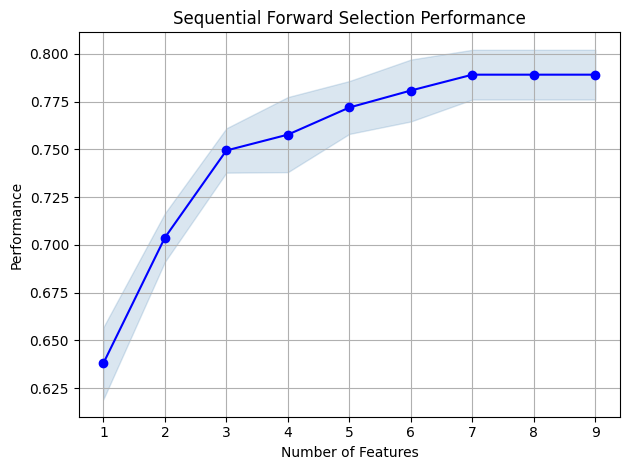

In [14]:
plt.figure(figsize=(10, 6))
plot_sfs(sfs.get_metric_dict())
plt.title('Sequential Forward Selection Performance')
plt.grid()
plt.tight_layout()
plt.show()

In [15]:
# Evaluate model with selected features
X_train_sfs = X_train[list(sfs.k_feature_names_)]
X_test_sfs = X_test[list(sfs.k_feature_names_)]

lr_sfs = LogisticRegression(max_iter=1000, random_state=42)
lr_sfs.fit(X_train_sfs, y_train)

sfs_train_accuracy = lr_sfs.score(X_train_sfs, y_train)
sfs_test_accuracy = lr_sfs.score(X_test_sfs, y_test)

print(f'SFS Training Accuracy: {sfs_train_accuracy*100:.2f}%')
print(f'SFS Testing Accuracy: {sfs_test_accuracy*100:.2f}%')


SFS Training Accuracy: 78.79%
SFS Testing Accuracy: 74.70%


## Sequential Backward Selection

Sequential forward selection was able to find a feature subset that performed marginally better than the full feature set. Let's use a different sequential method and see how it compares.

Create a sequential backward selection model called `sbs`. 
* Be sure to set the `estimator` parameter to `lr` and set the `forward` and `floating` parameters to the appropriate values.
* Also use the parameters `k_features=7`, `scoring='accuracy'`, and `cv=0`.

In [16]:
# Create and fit sequential backward floating selection model
sbs = SFS(
    lr, 
    k_features=7, 
    forward=False, 
    floating=True, 
    scoring='accuracy', 
    cv=5,  # Use 5-fold cross-validation
    n_jobs=-1  # Use all available cores
)

print("Performing Sequential Backward Floating Selection...")
sbs.fit(X_train, y_train)


Performing Sequential Backward Floating Selection...


SequentialFeatureSelector(estimator=LogisticRegression(max_iter=1000,
                                                       random_state=42),
                          floating=True, forward=False, k_features=(7, 7),
                          n_jobs=-1, scoring='accuracy')

### Fit the model

Use the `.fit()` method on `sbs` to fit the model to `X` and `y`.

### Inspect the results

Now that you've run the sequential backward selection algorithm on the logistic regression model with `X` and `y` you can see what features were chosen and check the model accuracy on the smaller feature set. Print `sbs.subsets_[7]` to inspect the results of sequential backward selection.

In [17]:
for key, value in sbs.subsets_[7].items():
    print(f'{key}: {value}')

feature_idx: (0, 1, 2, 3, 6, 9, 10)
cv_scores: [0.76923077 0.78106509 0.77218935 0.81305638 0.80712166]
avg_score: 0.7885326497287236
feature_names: ('Gender', 'Age', 'family_history_with_overweight', 'FAVC', 'CAEC', 'SCC', 'FAF')


### Chosen features and model accuracy

Use the dictionary `sbs.subsets_[7]` to print a tuple of chosen feature names. Then use it to print the accuracy of the model after doing sequential backward selection. How does this compare to the model's accuracy on all available features?

In [18]:
print(f'Feature names: {sbs.subsets_[7]['feature_names']}')
print(f'Accuracy score: {sbs.subsets_[7]['avg_score']}')

Feature names: ('Gender', 'Age', 'family_history_with_overweight', 'FAVC', 'CAEC', 'SCC', 'FAF')
Accuracy score: 0.7885326497287236


### Visualize model accuracy

You can visualize the results of sequential backward floating selection just as you did with sequential forward selection. Use the code `plot_sfs(sbs.get_metric_dict())` to plot the model accuracy as a function of the number of features used.

<Figure size 1000x600 with 0 Axes>

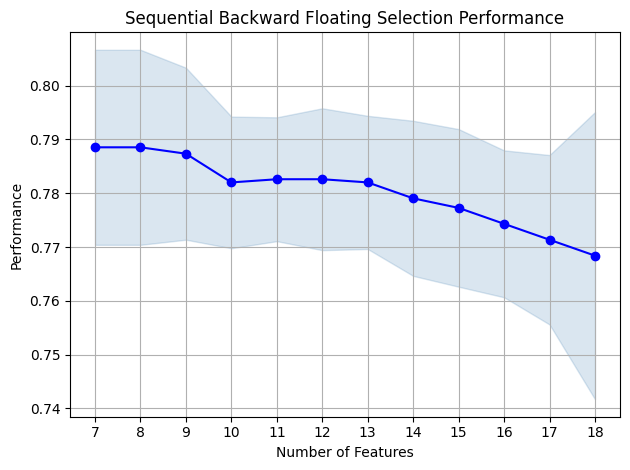

In [19]:
# Visualize feature selection process
plt.figure(figsize=(10, 6))
plot_sfs(sbs.get_metric_dict())
plt.title('Sequential Backward Floating Selection Performance')
plt.grid()
plt.tight_layout()
plt.show()


In [20]:
# Evaluate model with selected features
X_train_sbs = X_train[list(sbs.k_feature_names_)]
X_test_sbs = X_test[list(sbs.k_feature_names_)]

lr_sbs = LogisticRegression(max_iter=1000, random_state=42)
lr_sbs.fit(X_train_sbs, y_train)

sbs_train_accuracy = lr_sbs.score(X_train_sbs, y_train)
sbs_test_accuracy = lr_sbs.score(X_test_sbs, y_test)

print(f'SBS Training Accuracy: {sbs_train_accuracy*100:.2f}%')
print(f'SBS Testing Accuracy: {sbs_test_accuracy*100:.2f}%')

SBS Training Accuracy: 78.61%
SBS Testing Accuracy: 74.94%


## Recursive Feature Elimination

So far you've tried two different sequential feature selection methods. Let's try one more: recursive feature elimination. First you'll standardize the data, then you'll fit the RFE model and inspect the results.

At a later step of this project, you'll need to be able to access feature names. Enter the code `features = X.columns` for use later.

### Standardize the data

Before doing applying recursive feature elimination it is necessary to standardize the data. Standardize `X` and save it as a DataFrame by creating a `StandardScaler()` object and using the `.fit_transform()` method.

In [21]:
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(
    scaler.fit_transform(X_train),
    columns=features
)
X_test_scaled = pd.DataFrame(
    scaler.transform(X_test),
    columns=features
)


### Recursive feature elimination model

Create an `RFE()` object that selects `8` features. Be sure to set the `estimator` parameter to `lr`.

### Fit the model

Fit the recursive feature elimination model to `X` and `y`.

In [22]:
# Create and fit RFE model
rfe = RFE(
    estimator=lr,
    n_features_to_select=8,
    step=1,  # Remove one feature at a time
    verbose=1
)

print("Performing Recursive Feature Elimination...")
rfe.fit(X_train_scaled, y_train)


Performing Recursive Feature Elimination...
Fitting estimator with 18 features.
Fitting estimator with 17 features.
Fitting estimator with 16 features.
Fitting estimator with 15 features.
Fitting estimator with 14 features.
Fitting estimator with 13 features.
Fitting estimator with 12 features.
Fitting estimator with 11 features.
Fitting estimator with 10 features.
Fitting estimator with 9 features.


RFE(estimator=LogisticRegression(max_iter=1000, random_state=42),
    n_features_to_select=8, verbose=1)

### Inspect chosen features

Now that you've fit the RFE model you can evaluate the results. Create a list of chosen feature names and call it `rfe_features`. You can use a list comprehension and filter the features in `zip(features, rfe.support_)` based on whether their support is `True` (meaning the model kept them) or `False` (meaning the model eliminated them).

In [23]:
# Identify selected features
rfe_features = [feature for feature, support in zip(features, rfe.support_) if support]
print("\nRFE Results:")
print(f'Selected features: {rfe_features}')

# Create feature ranking
feature_ranking = pd.DataFrame({
    'Feature': features,
    'Ranking': rfe.ranking_
}).sort_values(by='Ranking')
print("\nFeature Ranking (1 = Selected):")
print(feature_ranking)



RFE Results:
Selected features: ['Age', 'family_history_with_overweight', 'FAVC', 'FCVC', 'CAEC', 'SCC', 'Automobile', 'Walking']

Feature Ranking (1 = Selected):
                           Feature  Ranking
17                         Walking        1
1                              Age        1
2   family_history_with_overweight        1
3                             FAVC        1
4                             FCVC        1
6                             CAEC        1
13                      Automobile        1
9                              SCC        1
10                             FAF        2
16           Public_Transportation        3
15                       Motorbike        4
11                             TUE        5
0                           Gender        6
8                             CH2O        7
7                            SMOKE        8
12                            CALC        9
5                              NCP       10
14                            Bike       11


### Model accuracy

Use the `.score()` method on `rfe` and print the model accuracy after doing recursive feature elimination. How does this compare to the model's accuracy on all available features?

In [25]:
# Evaluate model with selected features
X_train_rfe = X_train_scaled[rfe_features]
X_test_rfe = X_test_scaled[rfe_features]

lr_rfe = LogisticRegression(max_iter=1000, random_state=42)
lr_rfe.fit(X_train_rfe, y_train)

rfe_train_accuracy = lr_rfe.score(X_train_rfe, y_train)
rfe_test_accuracy = lr_rfe.score(X_test_rfe, y_test)

print(f'RFE Training Accuracy: {rfe_train_accuracy*100:.2f}%')
print(f'RFE Testing Accuracy: {rfe_test_accuracy*100:.2f}%')

RFE Training Accuracy: 77.49%
RFE Testing Accuracy: 73.76%


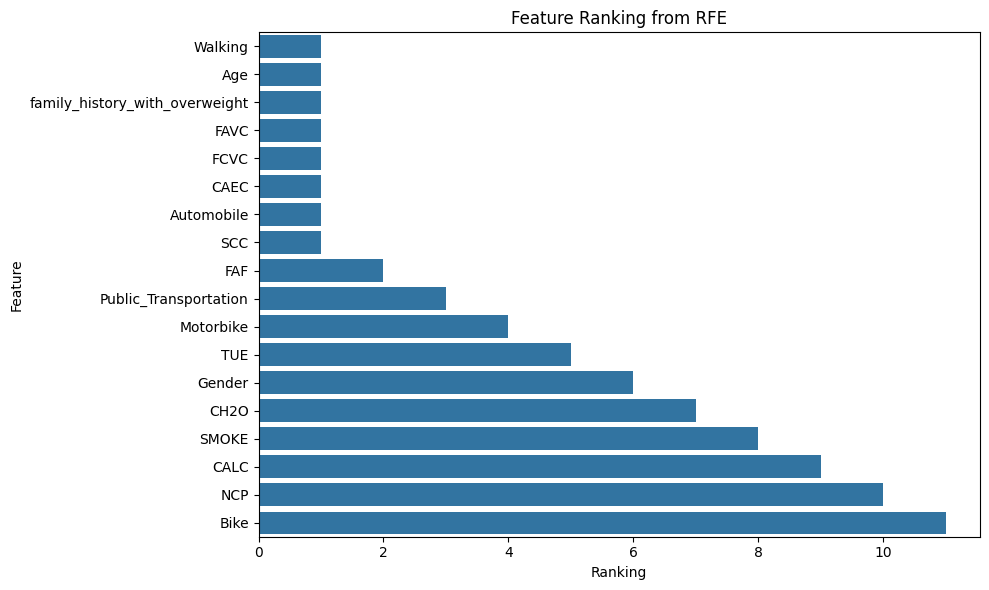

In [26]:
# Visualize RFE feature importance
plt.figure(figsize=(10, 6))
sns.barplot(x='Ranking', y='Feature', data=feature_ranking)
plt.title('Feature Ranking from RFE')
plt.tight_layout()
plt.show()

In [27]:
methods = ['All Features', 'SFS (9 features)', 'SBS (7 features)', 'RFE (8 features)']
train_accuracies = [train_accuracy, sfs_train_accuracy, sbs_train_accuracy, rfe_train_accuracy]
test_accuracies = [test_accuracy, sfs_test_accuracy, sbs_test_accuracy, rfe_test_accuracy]

comparison = pd.DataFrame({
    'Method': methods,
    'Training Accuracy': [acc*100 for acc in train_accuracies],
    'Testing Accuracy': [acc*100 for acc in test_accuracies]
})

print("Method Comparison:")
print(comparison)

Method Comparison:
             Method  Training Accuracy  Testing Accuracy
0      All Features          77.606635         73.995272
1  SFS (9 features)          78.791469         74.704492
2  SBS (7 features)          78.613744         74.940898
3  RFE (8 features)          77.488152         73.758865


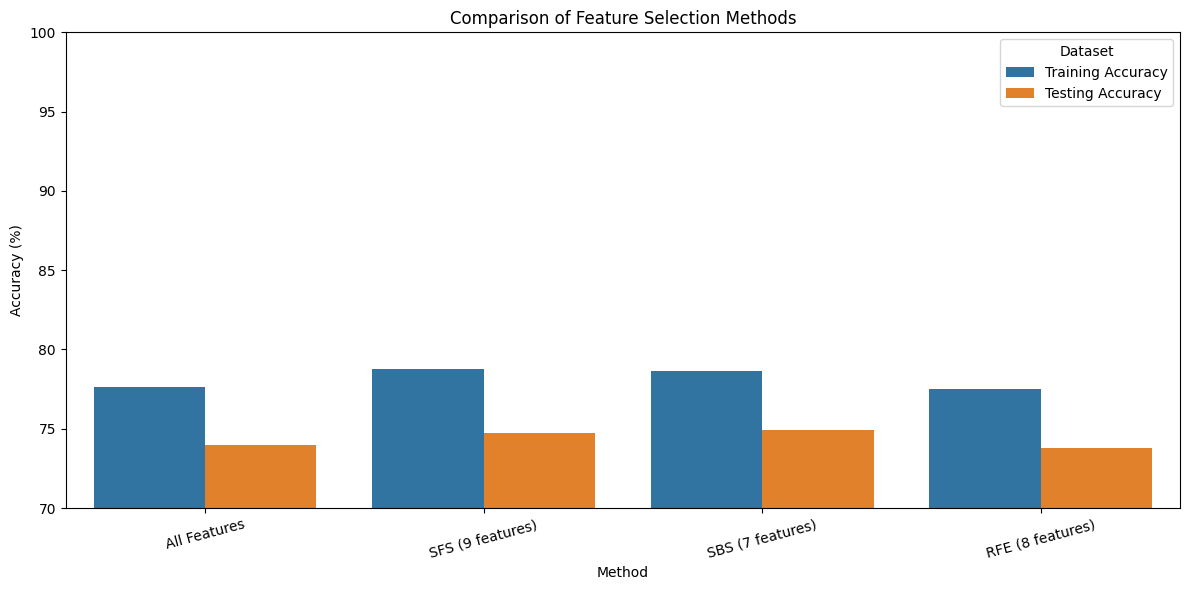

In [28]:
# Create a visualization of the comparison
plt.figure(figsize=(12, 6))
comparison_melted = pd.melt(comparison, id_vars='Method', var_name='Dataset', value_name='Accuracy (%)')
sns.barplot(x='Method', y='Accuracy (%)', hue='Dataset', data=comparison_melted)
plt.title('Comparison of Feature Selection Methods')
plt.ylim(70, 100)  # Adjust as needed based on actual accuracies
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()